Para o desafio sa Semana 4 do IEEE CIS, iremos utilizar CNNs (Convolutional Neural Networks) para reconhecimento de imagens do banco de dados Classificação - Cachorros, Gatos e Pandas

In [ ]:
#Passo 1 - Organizar os arquivos no formato de subpastar solicitado pelo método flow_from_directory do TensorFlow

import os
import shutil
import random

def organize_dataset(base_dir, split_ratios=(0.7, 0.2, 0.1)):
    # Criar diretórios principais usando o os.path
    # Esta função constrói um caminho de diretório sem se preocupar com os delimitadores de diretório específicos do sistema operacional
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    val_dir = os.path.join(base_dir, 'validation')
    
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory): #Confere se os diretórios já estão criados
            os.mkdir(directory)

    classes = ['cats', 'dogs', 'panda']
    
    for cls in classes:
        original_cls_dir = os.path.join(base_dir, cls)
        train_cls_dir = os.path.join(train_dir, cls)
        val_cls_dir = os.path.join(val_dir, cls)
        test_cls_dir = os.path.join(test_dir, cls)

        for directory in [train_cls_dir, val_cls_dir, test_cls_dir]:
            if not os.path.exists(directory):
                os.mkdir(directory)

        # Pegando todos os arquivos da classe atual e embaralhando
        all_files = os.listdir(original_cls_dir)
        random.shuffle(all_files)

        # Dividindo os arquivos
        n_total = len(all_files)
        n_train = int(n_total * split_ratios[0])
        n_val = int(n_total * split_ratios[1])
        
        train_files = all_files[:n_train]
        val_files = all_files[n_train:n_train+n_val]
        test_files = all_files[n_train+n_val:]

        # Mover arquivos para os respectivos diretórios
        for file in train_files:
            shutil.move(os.path.join(original_cls_dir, file), train_cls_dir)
            
        for file in val_files:
            shutil.move(os.path.join(original_cls_dir, file), val_cls_dir)
            
        for file in test_files:
            shutil.move(os.path.join(original_cls_dir, file), test_cls_dir)
        
        # Removendo o diretório original da classe após a organização
        os.rmdir(original_cls_dir)

# Chamando a função
base_directory = 'animals'  # Atualize com o caminho da sua pasta
organize_dataset(base_directory)


## Configuração da CNN

In [2]:
# Importando as bibliotecas e funções necessárias do TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definindo constantes para uso posterior no código

IMG_SIZE = (160, 160)  # Define o tamanho das imagens a serem processadas
BATCH_SIZE = 32 #Quantidade de features por vez no dataset
epochs = 20 #Quantidade de vezes que passaremos pelo dataset
learning_rate = 0.0001


### Modelo Keras

In [3]:
#Definição do modelo sequencial Keras
model = Sequential([
    # Primeira camada convolucional: 32 filtros, kernel de tamanho 3x3, ativação ReLU
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    # Camada de pooling para reduzir a dimensionalidade
    MaxPooling2D(2, 2),

    # Segunda camada convolucional: 64 filtros, kernel de tamanho 3x3, ativação ReLU
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Terceira camada convolucional: 128 filtros, kernel de tamanho 3x3, ativação ReLU
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten converte o tensor 3D em 1D para ser usado em camadas totalmente conectadas
    Flatten(),
    # Camada densa (totalmente conectada) com 512 neurônios e ativação ReLU
    Dense(512, activation='relu'),

    # Camada de saída com 3 neurônios (cada um para uma classe) e ativação softmax para classificação
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

### Pré-Processamento

In [4]:
#Compilando o modelo e definindo as métricas
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definindo caminhos para os diretórios de treinamento, validação e teste
train_dir = 'animals/train'
val_dir = 'animals/validation'
test_dir = 'animals/test'

In [5]:
# LAYER RESCALING para valores dos pixels de 0 a 1
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
# Configura o gerador de dados de treinamento para ler imagens do dataset, redimensioná-las e agrupá-las em lotes
train_generator = train_datagen.flow_from_directory(
    'animals/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2100 images belonging to 3 classes.


In [7]:
# Configura o gerador de dados de validação
val_generator = val_datagen.flow_from_directory(
    'animals/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 600 images belonging to 3 classes.


In [8]:
# Configura o gerador de dados de Teste
test_generator = val_datagen.flow_from_directory(
    'animals/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 300 images belonging to 3 classes.


### Treinamento da CNN

In [9]:
# Inicia o treinamento do modelo usando os geradores de treinamento e validação
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Define o número de épocas de treinamento
    verbose=1   # Define o nível de verbosidade (1 mostra o progresso das épocas)
)

Epoch 1/15
66/66 [==============================] - 15s 224ms/step - loss: 1.0309 - accuracy: 0.5443 - val_loss: 0.8318 - val_accuracy: 0.5700
Epoch 2/15
66/66 [==============================] - 15s 232ms/step - loss: 0.6794 - accuracy: 0.6700 - val_loss: 0.7270 - val_accuracy: 0.6517
Epoch 3/15
66/66 [==============================] - 15s 221ms/step - loss: 0.5597 - accuracy: 0.7314 - val_loss: 0.6568 - val_accuracy: 0.6983
Epoch 4/15
66/66 [==============================] - 14s 219ms/step - loss: 0.4493 - accuracy: 0.7967 - val_loss: 0.7622 - val_accuracy: 0.6900
Epoch 5/15
66/66 [==============================] - 15s 222ms/step - loss: 0.3315 - accuracy: 0.8557 - val_loss: 0.7456 - val_accuracy: 0.7050
Epoch 6/15
66/66 [==============================] - 15s 222ms/step - loss: 0.2395 - accuracy: 0.9033 - val_loss: 1.0347 - val_accuracy: 0.6967
Epoch 7/15
66/66 [==============================] - 15s 223ms/step - loss: 0.2019 - accuracy: 0.9286 - val_loss: 1.0149 - val_accuracy: 0.7017

<Figure size 640x480 with 0 Axes>

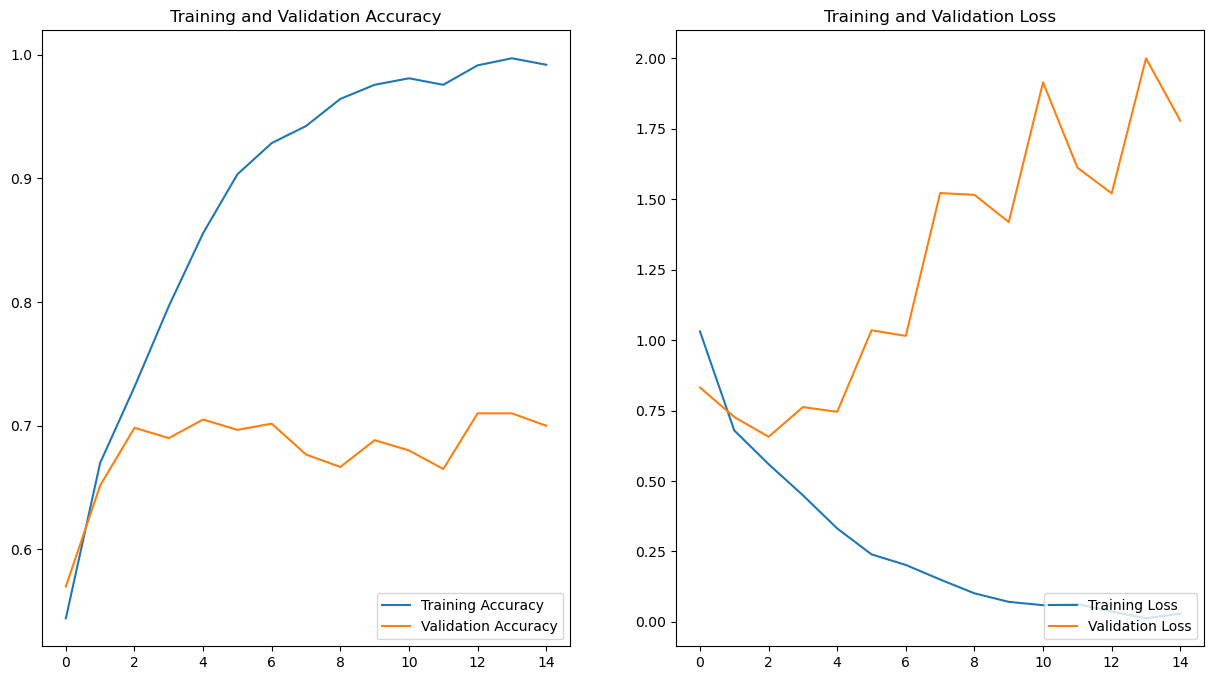

In [10]:
import matplotlib.pyplot as plt
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(15)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()
    
plot_model()

Podemos perceber que ocorreu um Overfitting no modelo para o dataset de treino, equanto para o de validação a acurácia foi de 70%. 

### Análise visual das imagens misclassified

1/1 [==============================] - 0s 67ms/step


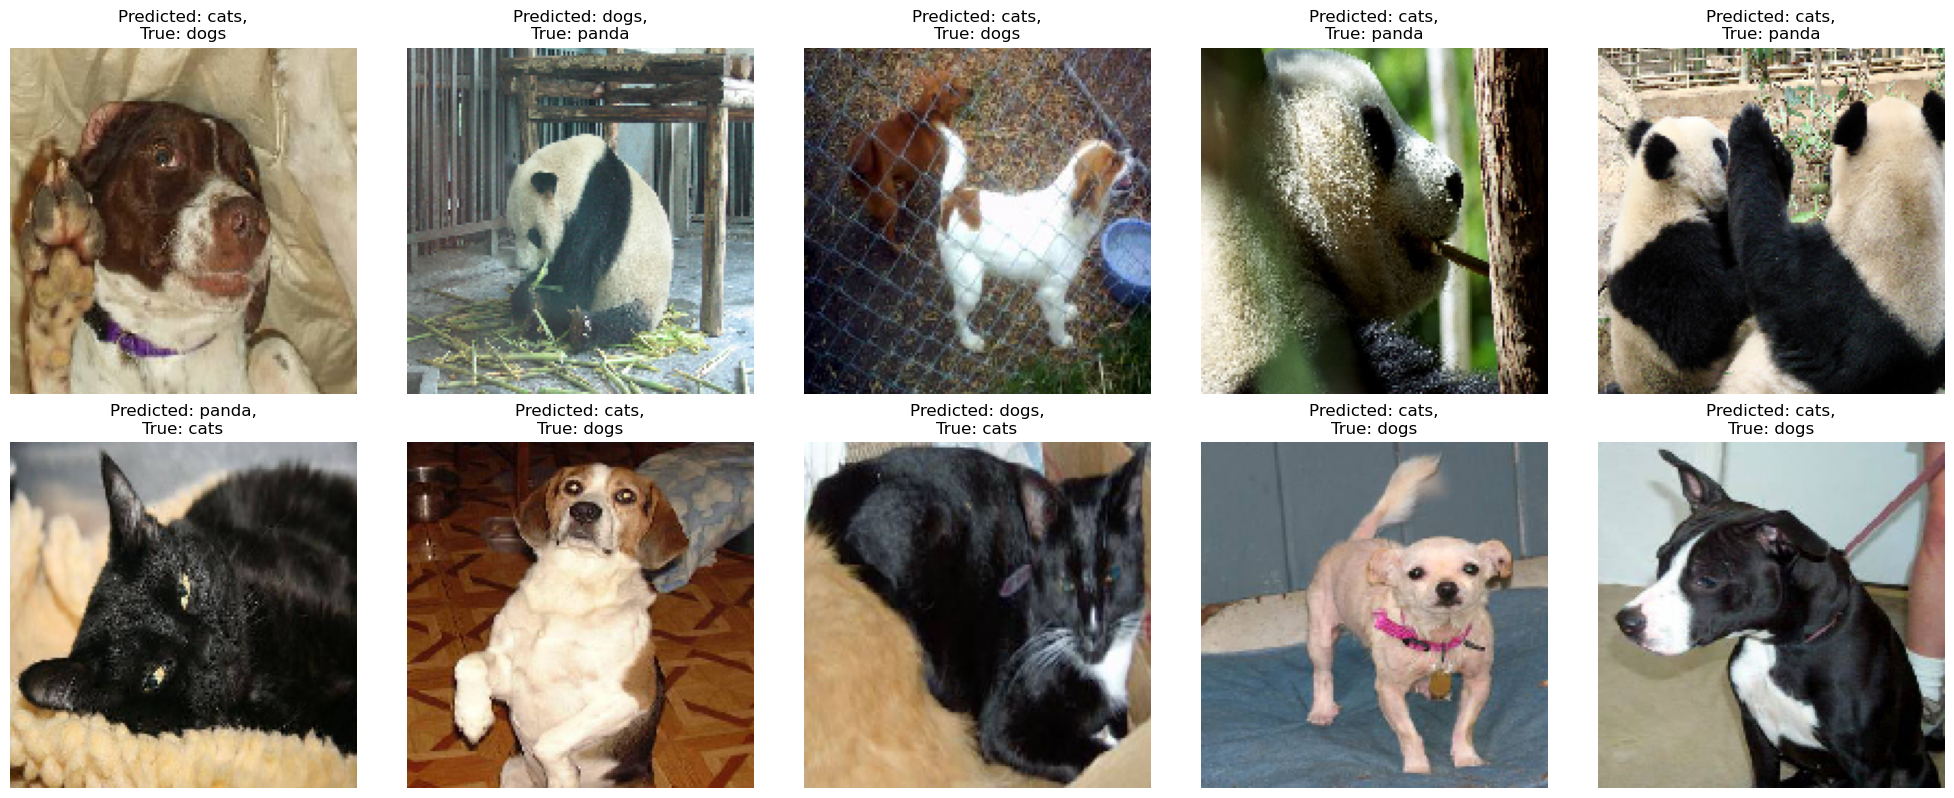

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Mapeia os índices das classes aos seus respectivos nomes
class_names = ['cats', 'dogs', 'panda']

# Pega um lote de imagens e etiquetas do conjunto de teste
test_images, test_labels = next(test_generator)

# Faz previsões usando o modelo
predictions = model.predict(test_images)

# Converte as previsões e etiquetas para as classes reais
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Identifica as imagens erradas
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

# Plota as primeiras N imagens erradas
N = min(10, len(incorrect_indices))
plt.figure(figsize=(20, 12))

for i, incorrect in enumerate(incorrect_indices[:N]):
    plt.subplot(3, 5, i + 1)  # 3 fileiras e 5 colunas
    plt.imshow(test_images[incorrect])
    plt.title(f"Predicted: {class_names[predicted_classes[incorrect]]},\nTrue: {class_names[true_classes[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Transfer Learning usando o modelo VGG16 do Keras

In [ ]:
from tensorflow.keras.applications import VGG16

# Carrega o modelo VGG16 pré-treinado sem a parte superior
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])
# Congela todas as camadas do modelo base, para não criar ruído no modelo durante o treinamento
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1
)

1/1 [==============================] - 1s 1s/step


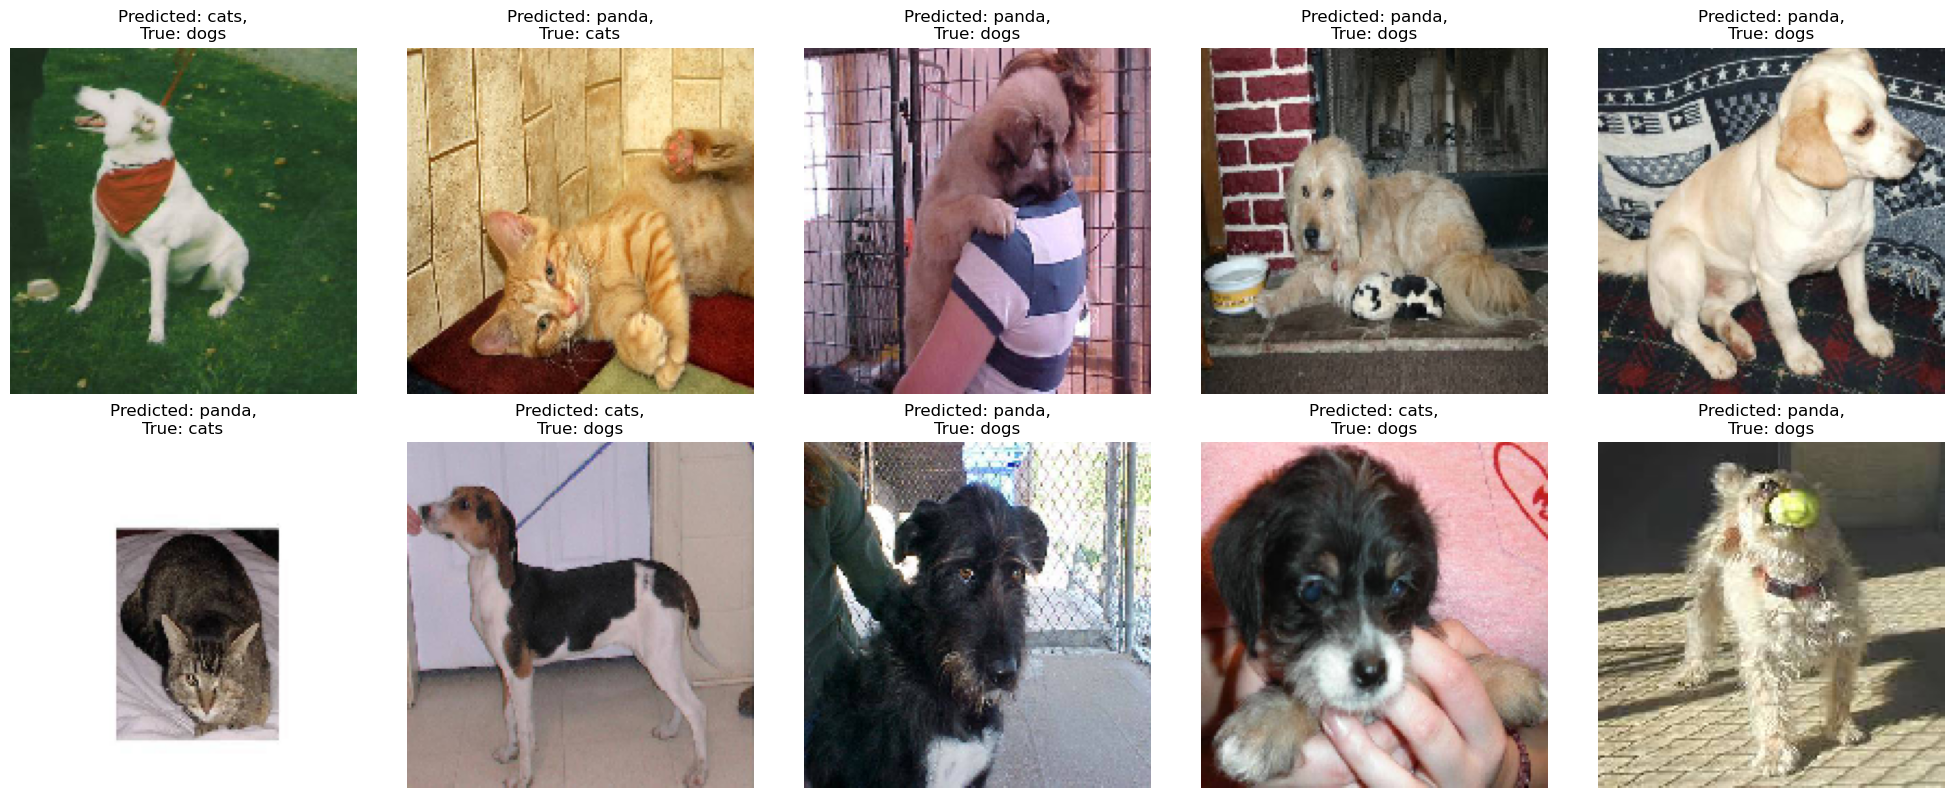

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Mapeia os índices das classes aos seus respectivos nomes
class_names = ['cats', 'dogs', 'panda']

# Pega um lote de imagens e etiquetas do conjunto de teste
test_images, test_labels = next(test_generator)

# Faz previsões usando o modelo
predictions = model.predict(test_images)

# Converte as previsões e etiquetas para as classes reais
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Identifica as imagens erradas
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

# Plota as primeiras N imagens erradas
N = min(10, len(incorrect_indices)) 
plt.figure(figsize=(20, 12))

for i, incorrect in enumerate(incorrect_indices[:N]):
    plt.subplot(3, 5, i + 1)  # 3 fileiras e 5 colunas
    plt.imshow(test_images[incorrect])
    plt.title(f"Predicted: {class_names[predicted_classes[incorrect]]},\nTrue: {class_names[true_classes[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Podemos ver que o número de erros foi maior para Pandas, o que pode ser esperado, pois é possível que esse modelo tenha sido treinado com mais imagens de gatos e cachorros e não tantas de pandas.

<Figure size 640x480 with 0 Axes>

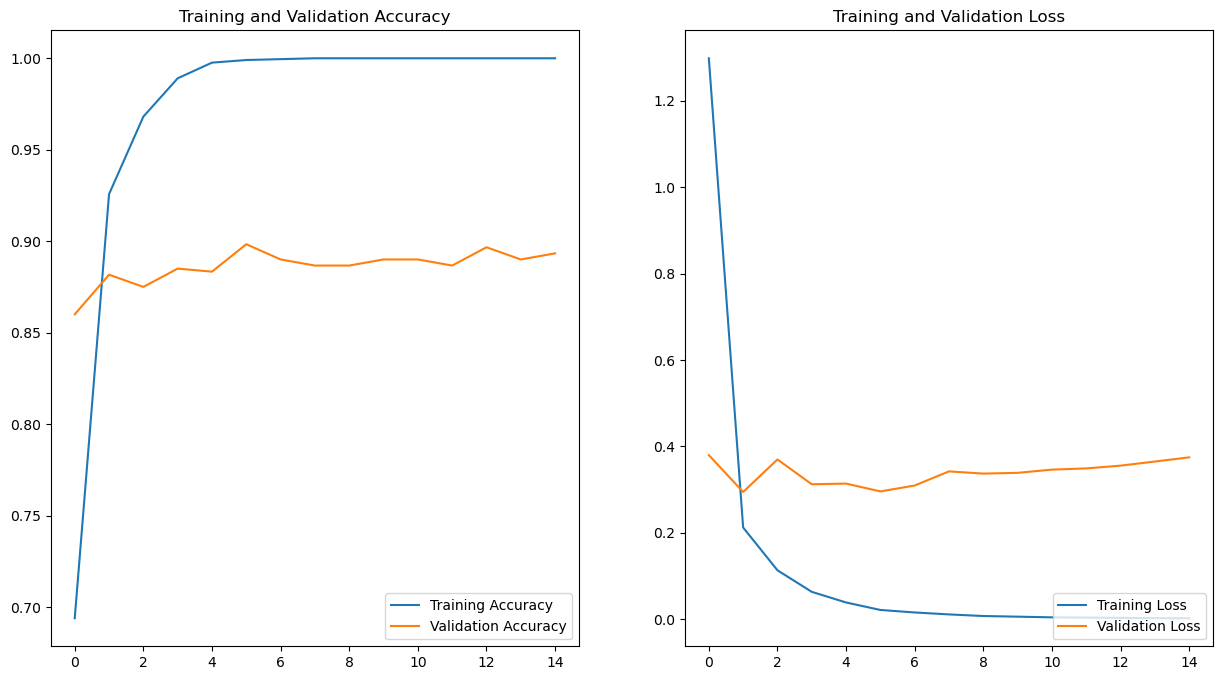

In [28]:
plot_model()

Agora com modelo VGG16 podemos perceber que o modelo se portou bem melhor, tendo quase 90% de acurácia, e refuzindo drasticamente o Loss.

# Data Augmentation

O Data Augmentation é uma técnica que permite gerar novas imagens de treinamento aplicando transformações, como rotações, deslocamentos e inversões no conjunto de imagens original. Isso ajuda a tornar o modelo mais robusto e a evitar o overfitting.

In [31]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

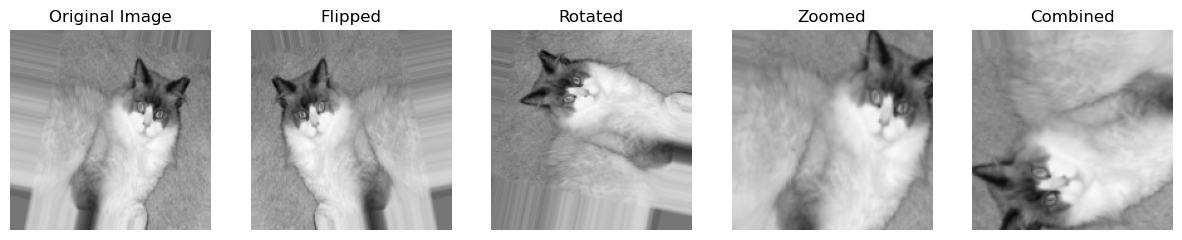

In [48]:
def plot_single_image_augmentations(train_generator):
    plt.figure(figsize=(15, 5))

    # Pega um batch de imagens e seus respectivos rótulos
    features, _ = next(train_generator)
    image = features[0]
    
    # Converter as cores para uint8
    image = tf.cast(image * 255, tf.uint8)

    # Original Image
    plt.subplot(1, 5, 1)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.title("Original Image")
    plt.axis("off")

    # Flip
    flipped = tf.image.flip_left_right(image)
    plt.subplot(1, 5, 2)
    plt.imshow(tf.cast(flipped, tf.uint8))
    plt.title("Flipped")
    plt.axis("off")

    # Rotate
    rotated = tf.image.rot90(image)
    plt.subplot(1, 5, 3)
    plt.imshow(tf.cast(rotated, tf.uint8))
    plt.title("Rotated")
    plt.axis("off")

    # Zoom
    zoom = tf.image.central_crop(image, central_fraction=0.7)
    zoom = tf.image.resize(zoom, (image.shape[0], image.shape[1]))
    plt.subplot(1, 5, 4)
    plt.imshow(tf.cast(zoom, tf.uint8))
    plt.title("Zoomed")
    plt.axis("off")

    # Combined
    combined = tf.image.rot90(flipped)
    combined = tf.image.central_crop(combined, central_fraction=0.7)
    combined = tf.image.resize(combined, (image.shape[0], image.shape[1]))
    plt.subplot(1, 5, 5)
    plt.imshow(tf.cast(combined, tf.uint8))
    plt.title("Combined")
    plt.axis("off")

    plt.show()

# Chame a função com o train_generator
plot_single_image_augmentations(train_generator)
